In [73]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from randomizedSVD import rsvd

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 13

colors5 = [
    "#648FFF",
    "#785EF0",
    "#DC267F",
    "#FE6100",
    "#FFB000"
]
colors3 = [
    "#648FFF",
    "#785EF0",
    "#DC267F",
]

In [69]:
def exp_decay(n, C, alpha):
    """
    Generate an exponentially decaying sequence x_k = C * exp(-alpha * k).
    """
    k = np.arange(n)
    return C * np.exp(-alpha * k)


def poly_decay(n, C, p, alpha):
    """
    Generate a polynomial decaying sequence x_k = C / (1 + alpha * k)^p.
    """
    k = np.arange(n)
    return C / (1 + alpha * k) ** p


def random_orthogonal_matrix(n):
    """
    A random orthogonal matrix from an uniform distribution (distribution 
    given by Haar measure).
    """
    Omega = np.random.randn(n, n)
    Q, R = np.linalg.qr(Omega)
    return Q * np.sign(np.diag(R))


def random_test_matrix(singular_values):
    """
    Get a random test matrix with the given singular values.
    """
    n = len(singular_values)
    U = random_orthogonal_matrix(n)
    V = random_orthogonal_matrix(n)
    S = np.diag(singular_values)
    return U @ S @ V.T


def trsvd(A, k, p):
    """
    Get the rank-k truncated matrix Ak of a matrix A using
    randomized SVD with oversampling parameter p.
    """
    Uk, Sk, VkT = rsvd(A, k, p)
    return Uk @ np.diag(Sk) @ VkT


def errors_rsvd(singular_values, k_min, k_max, repeats, p=5):
    """
    Construct matrices with the given singular value distribution, and compute the l2
    errors of the rank-k approximation using randomized SVD with oversampling parameter p.
    """
    k_range = np.arange(k_min, k_max)
    errors = np.zeros((repeats, k_max - k_min))
    for r in range(repeats):
        for i, k in enumerate(k_range):
            A = random_test_matrix(singular_values)
            Ak = trsvd(A, k, p)
            e = np.linalg.norm(A - Ak, 2)
            errors[r, i] = e
    return errors


def errors_rsvd_expected(singular_values):
    ...

In [70]:
# Construct matrices with a given singular decay
n = 50
C = 10
p = 2
alphas = np.array([0.01, 0.2, 0.75])

Ss = [poly_decay(n, C, p, alpha) for alpha in alphas]

k_min, k_max = 5, 45
nk = k_max - k_min
repeats = 50
errors0 = errors_rsvd(Ss[0], k_min, k_max, repeats)
errors1 = errors_rsvd(Ss[1], k_min, k_max, repeats)
errors2 = errors_rsvd(Ss[2], k_min, k_max, repeats)
errors = [errors0, errors1, errors2]

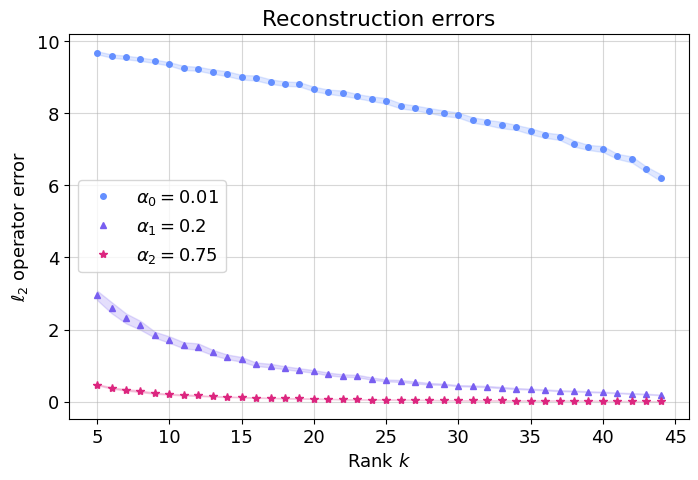

In [74]:
# Make a p% confidence interval
p = 99
z = norm.ppf((1 + p / 100) / 2)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
k_range = np.arange(k_min, k_max)

styles = ['-', '--', '-.']
markers = ['o', '^', '*']
sizes = [4, 5, 6]
for i in range(len(errors)):
    mean_error = errors[i].mean(axis=0)
    std = errors[i].std(axis=0)
    nk = errors[i].shape[0]
    ci95 = z * std / np.sqrt(nk)

    ax.plot(k_range, mean_error, markers[i], c=colors3[i],
            label=f'$\\alpha_{i}={alphas[i]}$', ms=sizes[i])
    #ax.plot(k_range, mean_error, color=colors3[i], lw=2, alpha=0.5)
    ax.fill_between(k_range, mean_error - ci95, mean_error + ci95, color=colors3[i], alpha=0.2)

ax.set_xlabel('Rank $k$')
ax.set_ylabel('$\\ell_2$ operator error')
ax.set_title('Reconstruction errors')
ax.legend()
ax.grid(True, alpha=0.5)
plt.show()

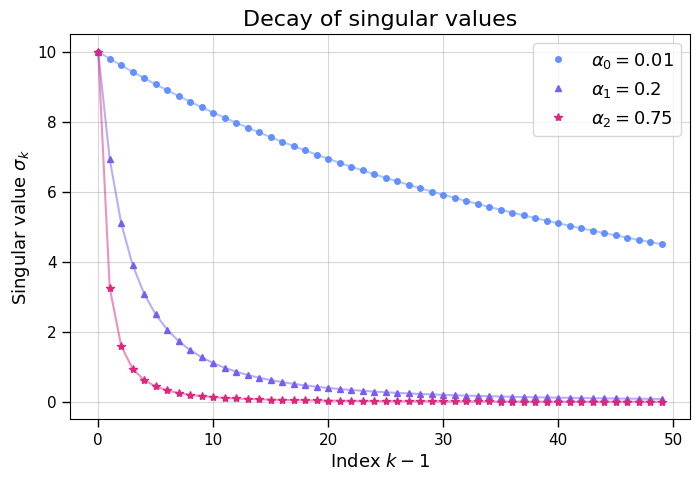

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

markers = ['o', '^', '*']
sizes = [4, 5, 6]

for i in range(len(Ss)):
    ax.plot(np.arange(n), Ss[i], markers[i],
            c=colors3[i], ms=sizes[i], label=f'$\\alpha_{i}={alphas[i]}$')
    ax.plot(np.arange(n), Ss[i], '-', c=colors3[i], ms=1, alpha=0.5)

ax.set_xlabel('Index $k-1$', fontsize=13)
ax.set_ylabel('Singular value $\\sigma_k$', fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
ax.tick_params(axis='both', which='minor', length=3, color='gray')

ax.grid(True, alpha=0.5)
ax.set_title("Decay of singular values", fontsize=16)
ax.legend()

plt.savefig("../figures/singular_value_decay.png")
plt.show()